In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
da1 = np.load('embeddings_1.npy')
da2 = np.load('embeddings_2.npy')

In [2]:
da_all = np.vstack([da1,da2])
da_all.shape

(198982, 1024)

In [3]:
labels1 = pd.read_csv('icd_codes_1.txt',header = None)
labels1 = labels1[0].str.split(';')

In [4]:
labels2 = pd.read_csv('icd_codes_2.txt',header = None)
labels2 = labels2[0].str.split(';')

In [5]:
labels_all = pd.concat([labels1,labels2],axis = 0)

In [6]:
labels_all_tup = pd.Series([tuple(list) for list in labels_all])

In [7]:
data = pd.DataFrame(da_all)
data['Multilabels'] = labels_all_tup
data_uni = data.drop_duplicates(subset = data.columns[:-1],keep = False)

In [8]:
data_uni.shape

(195821, 1025)

In [9]:
labels_uni = data_uni['Multilabels']

In [10]:
def labels_in_cluster(cluster,labels_uni):
    '''
    cluster is a list of characters
    '''
    results = {}
    labels_all = [label for item in labels_uni for label in item]
    for cat in cluster:
        # print(set([label for label in labels_all if cat in label]))
        results[cat] = len(set([label for label in labels_all if label.startswith(cat)]))
    return results
        

In [11]:
import string
alphabets = list(string.ascii_uppercase)
label_dist_true = labels_in_cluster(alphabets,labels_uni)

In [12]:
data_uni.iloc[:,:-1].shape

(195821, 1024)

In [13]:
data_uni.iloc[:,-1].shape

(195821,)

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
X = data_uni.iloc[:,:-1]
y = pd.DataFrame(mlb.fit_transform(data_uni.iloc[:,-1]))

In [15]:
data_uni.iloc[:,-1]

1                                      (G89.29, M25.562)
2                (R13.10, K20.90, K31.89, K25.9, K29.80)
3              (K20.90, R10.11, Z86.010, K57.30, Z90.49)
4                 (R93.3, K29.50, R10.84, K31.89, R19.7)
5                                  (K62.5, K64.8, K64.5)
                               ...                      
198977    (K62.1, K64.8, Z86.010, Z12.11, K57.30, K63.5)
198978                   (Z12.11, Z86.010, K63.5, K64.8)
198979           (K62.1, K64.8, Z86.010, Z12.11, K57.30)
198980                                  (K20.90, K29.70)
198981                           (K63.5, K57.30, K63.89)
Name: Multilabels, Length: 195821, dtype: object

In [16]:
from tqdm import tqdm

In [17]:
# Collecting a sample of data for testing out models
from skmultilearn.model_selection.iterative_stratification import iterative_train_test_split
from collections import Counter
# Initialize the stratifier
X_train,y_train,X_test,y_test = iterative_train_test_split(np.array(X),np.array(y),test_size = 0.8)


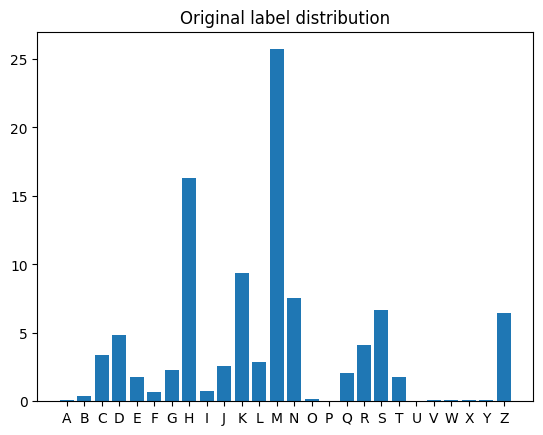

(0.0, 30.0)

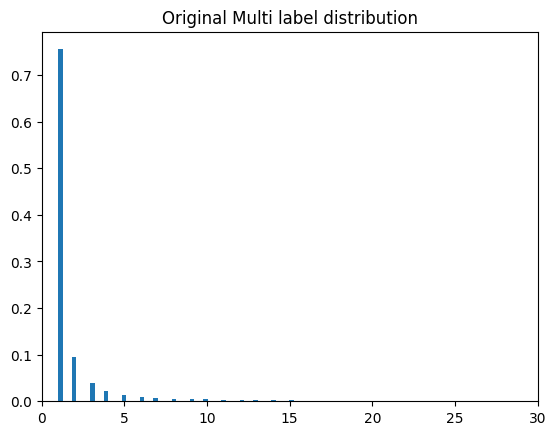

In [18]:
plt.figure(0)
alphas = label_dist_true.keys()
percents = np.fromiter(label_dist_true.values(),dtype = 'float32')
# print(percents)
percents = percents*100/np.sum(percents)
plt.bar(alphas,percents)
plt.title('Original label distribution')
plt.show()
#Need to check individual label is fixed
clustering_count = Counter()
for ml in labels_uni:
    clustering_count[ml] +=1

plt.figure(1)
plt.hist(clustering_count.values(),weights=np.ones(len(clustering_count.values())) / len(clustering_count.values()),bins = 10000)
plt.title('Original Multi label distribution')
plt.xlim(0,30)

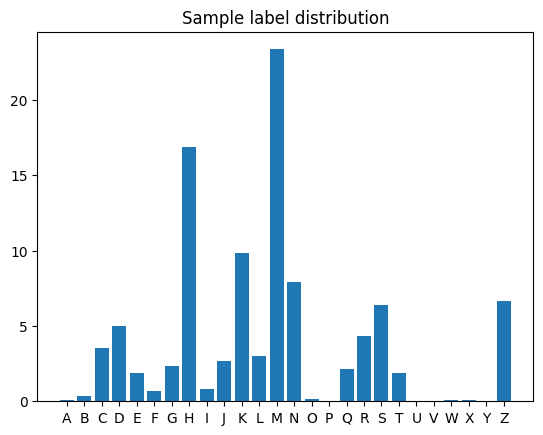

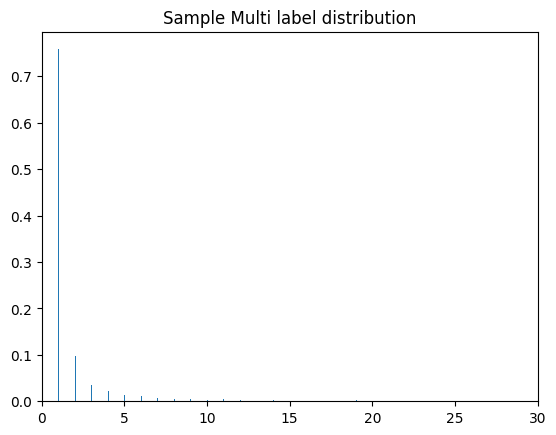

In [19]:
y_train_labels = mlb.inverse_transform(np.array(y_train))
# print(y_train_labels[0])
label_dist_sample = labels_in_cluster(alphabets,y_train_labels)
plt.figure(0)
alphas = label_dist_sample.keys()
percents = np.fromiter(label_dist_sample.values(),dtype = 'float32')
percents = percents*100/np.sum(percents)
plt.bar(alphas,percents)
plt.title('Sample label distribution')
plt.show()
#Need to check individual label is fixed
clustering_count = Counter()
for ml in y_train_labels:
    # print(ml)
    clustering_count[ml] +=1
# print(clustering_count)

plt.figure(1)
plt.hist(clustering_count.values(),weights=np.ones(len(clustering_count.values())) / len(clustering_count.values()),bins = 10000)
plt.title('Sample Multi label distribution')
plt.xlim(0,30)
plt.show()

In [20]:
import gc
gc.collect()

512978

In [55]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

In [53]:
def filter_data_points(embeddings,labels, labels_to_check):
    #retains the data only in the columns requested with rows appearing at least once in these columns
    filtered_labels = labels[np.any(labels[:, labels_to_check], axis=1)]
    filtered_embeddings = embeddings[np.any(labels[:, labels_to_check], axis=1)]
    return filtered_embeddings, filtered_labels

In [39]:
mlabels = mlb.classes_
labels_map = dict([(s,ind) for ind,s in enumerate(mlabels) if s.startswith('C')])

In [60]:
models = {}
for letter in tqdm(alphabets):
    # X should be embeddings, y should be multilabels
    indices  = [ind for ind,s in enumerate(mlabels) if s.startswith(letter)]
    filtered_data,filtered_labels = filter_data_points(X_train,y_train,indices)
    if len(indices) == 0
        continue
    else len(indices) == 1:
        mask = np.zeros((1,len(mlabels)))
        mask[0,indices[0]] = 1
        models[letter] = mlb.inverse_transform(mask)
    else:
        model = MultiOutputClassifier(RandomForestClassifier(n_estimators = 5,verbose = 2))
        model.fit(filtered_data,filtered_labels)
    # models[letter] = 

  0%|                                                                                                                                                                                      | 0/26 [00:00<?, ?it/s]

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree

  8%|█████████████▍                                                                                                                                                                | 2/26 [00:09<01:58,  4.95s/it]

building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree

 12%|████████████████████                                                                                                                                                          | 3/26 [00:31<04:37, 12.05s/it]

building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree

 15%|██████████████████████████▊                                                                                                                                                   | 4/26 [01:57<14:29, 39.52s/it]

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree

 19%|█████████████████████████████████▍                                                                                                                                            | 5/26 [02:15<11:10, 31.92s/it]

building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree

 23%|████████████████████████████████████████▏                                                                                                                                     | 6/26 [02:26<08:19, 24.97s/it]

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree

 27%|██████████████████████████████████████████████▊                                                                                                                               | 7/26 [03:10<09:50, 31.10s/it]

building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree

 31%|█████████████████████████████████████████████████████▌                                                                                                                        | 8/26 [06:41<26:19, 87.77s/it]

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree

 35%|████████████████████████████████████████████████████████████▏                                                                                                                 | 9/26 [06:53<18:14, 64.36s/it]

building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree

 38%|██████████████████████████████████████████████████████████████████▌                                                                                                          | 10/26 [09:15<23:30, 88.14s/it]

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree

 42%|████████████████████████████████████████████████████████████████████████▊                                                                                                   | 11/26 [13:31<34:48, 139.25s/it]

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree

 46%|███████████████████████████████████████████████████████████████████████████████▍                                                                                            | 12/26 [14:03<24:56, 106.88s/it]

building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree

 50%|██████████████████████████████████████████████████████████████████████████████████████                                                                                      | 13/26 [15:39<22:26, 103.56s/it]

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree

 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 14/26 [18:41<25:27, 127.31s/it]

building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 15/26 [18:51<13:49, 75.44s/it]

building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5
building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree

ValueError: Found array with 0 sample(s) (shape=(0, 1400)) while a minimum of 1 is required by MultiOutputClassifier.

In [41]:
models

{'A': [('A63.0',)],
 'V': [('V89.2XXA',)],
 'W': [('W19.XXXA',)],
 'X': [('X58.XXXA',)],
 'Y': [('Y33.XXXA',)]}

In [ ]:
# smalll sample of 40,000 data points that carry the same distribution
# train -20,000, valid - 15,000, test- 5,000

In [35]:
temp = np.zeros((1,len(mlabels)))
temp[0,0] = 1
mlb.inverse_transform(temp)

[('A63.0',)]

In [32]:
temp

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [61]:
len([])

0